In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('C:/Scaler_DSML/Project/ola_ensemble/ola_driver_scaler.csv')

In [4]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [5]:
# df.drop(['Unnamed: 0','MMM-YY'], axis=1, inplace=True)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [6]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

###	Analyzing basic metrics

##### o	Shape of data: Total of 19104 rows × 14 columns

##### o	Data types of all the attributes as received in source: 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                19104 non-null  object 
 1   Driver_ID             19104 non-null  int64  
 2   Age                   19043 non-null  float64
 3   Gender                19052 non-null  float64
 4   City                  19104 non-null  object 
 5   Education_Level       19104 non-null  int64  
 6   Income                19104 non-null  int64  
 7   Dateofjoining         19104 non-null  object 
 8   LastWorkingDate       1616 non-null   object 
 9   Joining Designation   19104 non-null  int64  
 10  Grade                 19104 non-null  int64  
 11  Total Business Value  19104 non-null  int64  
 12  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.9+ MB


### Identifying the `Missing values` across the all variables: 

In [8]:
df[df.columns[df.isnull().any()]].isnull().sum()

Age                   61
Gender                52
LastWorkingDate    17488
dtype: int64

### Checking null percentage

In [9]:
df[df.columns[df.isnull().any()]].isnull().sum() * 100 / df.shape[0]

Age                 0.319305
Gender              0.272194
LastWorkingDate    91.541039
dtype: float64

In [10]:
df.Gender.value_counts(normalize=True)*100

0.0    58.125131
1.0    41.874869
Name: Gender, dtype: float64

### Count duplicate rows on entire dataframe:

In [11]:
len(df)-len(df.drop_duplicates())

0

In [12]:
# (df[~df.LastWorkingDate.isna()]).loc[:,'Total Business Value'].value_counts()

### Checking the unique value counts in columns
* We’ll remove columns with only one unique value because their variance<br>
    will be 0 and they won’t help us anticipate anything.

In [13]:
data = df
featureValues={}
for d in data.columns.tolist():
    count=data[d].nunique()
    if count==1:
        featureValues[d]=count
# List of columns having same 1 unique value        
cols_to_drop= list(featureValues.keys())
print("Columns having 1 unique value are :",cols_to_drop)

Columns having 1 unique value are : []


### >`Convert Object to datetime type `<

In [14]:
df[['MMM-YY', 'Dateofjoining', 'LastWorkingDate']] = df[
    ['MMM-YY', 'Dateofjoining', 'LastWorkingDate']].apply(pd.to_datetime)

### >>`Understand Categorical features ` <<

#### o	Conversion of categorical attributes to 'category':
* It has helped in reduction of memory usage.

### `Update Numeric Ordinal data to category type:`

In [15]:
df[['City','Gender','Education_Level','Joining Designation','Grade', 'Quarterly Rating']]=df[
    ['City','Gender','Education_Level','Joining Designation','Grade', 'Quarterly Rating']].astype('category')

In [16]:
cat_cols = df.dtypes =='category'
cat_cols = list(cat_cols[cat_cols].index)

In [17]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Gender               19052 non-null  category
 1   City                 19104 non-null  category
 2   Education_Level      19104 non-null  category
 3   Joining Designation  19104 non-null  category
 4   Grade                19104 non-null  category
 5   Quarterly Rating     19104 non-null  category
dtypes: category(6)
memory usage: 114.2 KB


In [18]:
df[cat_cols].describe()

,Gender,City,Education_Level,Joining Designation,Grade,Quarterly Rating
count,19052.0,19104,19104,19104,19104,19104
unique,2.0,29,3,5,5,4
top,0.0,C20,1,1,2,1
freq,11074.0,1008,6864,9831,6627,7679


### `1. 'City' variable stats`
* Total of 29 cities
* C20 city has highest drivers 1008, then city 'C29' with 900 drivers.
* No Nulls in this variable

[Text(0, 0, '1008'),
 Text(0, 0, '900'),
 Text(0, 0, '869'),
 Text(0, 0, '809'),
 Text(0, 0, '786'),
 Text(0, 0, '761'),
 Text(0, 0, '744'),
 Text(0, 0, '727'),
 Text(0, 0, '712'),
 Text(0, 0, '709'),
 Text(0, 0, '683'),
 Text(0, 0, '677'),
 Text(0, 0, '660'),
 Text(0, 0, '656'),
 Text(0, 0, '648'),
 Text(0, 0, '637'),
 Text(0, 0, '614'),
 Text(0, 0, '609'),
 Text(0, 0, '603'),
 Text(0, 0, '584'),
 Text(0, 0, '579'),
 Text(0, 0, '578'),
 Text(0, 0, '569'),
 Text(0, 0, '544'),
 Text(0, 0, '538'),
 Text(0, 0, '520'),
 Text(0, 0, '472'),
 Text(0, 0, '468'),
 Text(0, 0, '440')]

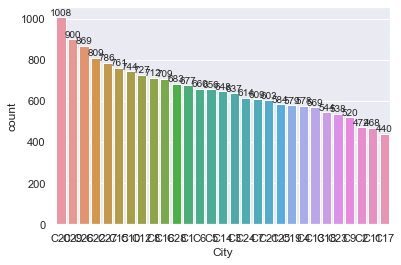

In [19]:
sns.set(rc={'figure.figsize':(12,5)})
ax = sns.countplot(data=df,x="City",order = df.City.value_counts().index)
ax.bar_label(container=ax.containers[0])

### `2. 'Education Level' variable stats`
* 0,1,2 are three categories of Education Level
* All Education_Level have close to equal percentage of drivers.
* No Nulls in this variable

In [20]:
df["Education_Level"].value_counts(normalize=True)*100

1    35.929648
2    33.118719
0    30.951633
Name: Education_Level, dtype: float64

[Text(0, 0, '6864'), Text(0, 0, '6327'), Text(0, 0, '5913')]

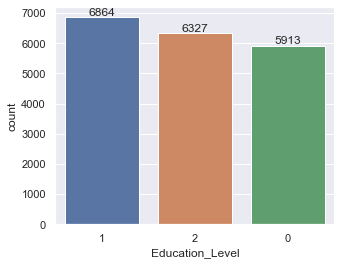

In [21]:
sns.set(rc={'figure.figsize':(5,4)})
ax=sns.countplot(data=df,x="Education_Level",order = df.Education_Level.value_counts().index)
ax.bar_label(container=ax.containers[0])

### `3. 'Joining Designation' variable stats`
* 51% (9831 rows) of drivers join on Designation 1, followed by '2' with 31% (5955 rows)
* No Nulls in this variable

In [22]:
df["Joining Designation"].value_counts(normalize=True)*100

1    51.460427
2    31.171482
3    14.902638
4     1.784966
5     0.680486
Name: Joining Designation, dtype: float64

[Text(0, 0, '9831'),
 Text(0, 0, '5955'),
 Text(0, 0, '2847'),
 Text(0, 0, '341'),
 Text(0, 0, '130')]

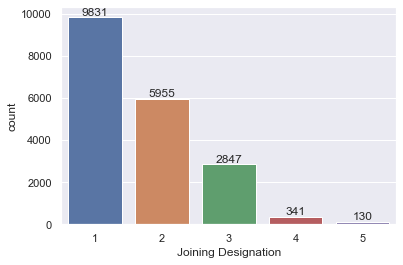

In [23]:
sns.set(rc={'figure.figsize':(6,4)})
ax=sns.countplot(data=df,x="Joining Designation",order = df["Joining Designation"].value_counts().index)
ax.bar_label(container=ax.containers[0])

### `4.  'Grade' variable stats`
* 34% (6627 rows) of drivers have Grade 2, followed by Grade '1' with 27% (5202 rows)
* No Nulls in this variable

In [24]:
df["Grade"].value_counts(normalize=True)*100

2    34.689070
1    27.229899
3    25.261725
4    11.222781
5     1.596524
Name: Grade, dtype: float64

[Text(0, 0, '6627'),
 Text(0, 0, '5202'),
 Text(0, 0, '4826'),
 Text(0, 0, '2144'),
 Text(0, 0, '305')]

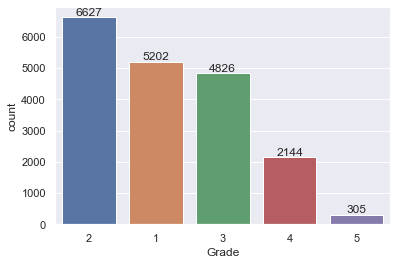

In [25]:
sns.set(rc={'figure.figsize':(6,4)})
ax=sns.countplot(data=df,x="Grade",order = df["Grade"].value_counts().index)
ax.bar_label(container=ax.containers[0])

### `5.  'Quarterly Rating' variable stats`
* 40% of drivers have Quarterly Rating 1, followed by Quarterly Rating '2' with 29%.
* No Nulls in this variable

In [26]:
df["Quarterly Rating"].value_counts(normalize=True)*100

1    40.195771
2    29.067211
3    20.388400
4    10.348618
Name: Quarterly Rating, dtype: float64

[Text(0, 0, '7679'),
 Text(0, 0, '5553'),
 Text(0, 0, '3895'),
 Text(0, 0, '1977')]

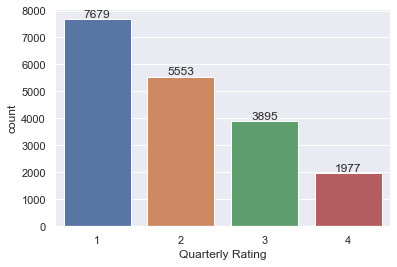

In [27]:
sns.set(rc={'figure.figsize':(6,4)})
ax=sns.countplot(data=df,x="Quarterly Rating",order = df["Quarterly Rating"].value_counts().index)
ax.bar_label(container=ax.containers[0])

### `6.  'Gender' variable stats`
* 58% of drivers are male, while 41% are female.
* No Nulls in this variable

In [28]:
df.Gender.value_counts(normalize=True)*100

0.0    58.125131
1.0    41.874869
Name: Gender, dtype: float64

<AxesSubplot:xlabel='Gender', ylabel='count'>

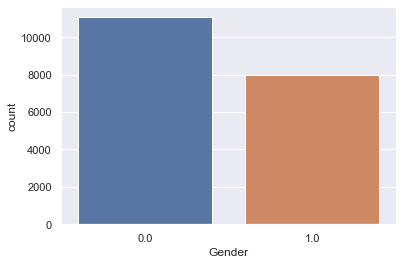

In [29]:
sns.countplot(data=df,x="Gender",order = df["Gender"].value_counts().index)

## >`Numerical features`<

In [30]:
num_cols = (df.dtypes =='int64') | (df.dtypes =='float64')
num_cols = list(num_cols[num_cols].index)
num_cols

['Driver_ID', 'Age', 'Income', 'Total Business Value']

In [31]:
df[num_cols[1:]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   19043 non-null  float64
 1   Income                19104 non-null  int64  
 2   Total Business Value  19104 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 447.9 KB


In [32]:
df[num_cols[1:]].describe()

,Age,Income,Total Business Value
count,19043.000000,19104.000000,1.910400e+04
mean,34.668435,65652.025126,5.716621e+05
std,6.257912,30914.515344,1.128312e+06
min,21.000000,10747.000000,-6.000000e+06
25%,30.000000,42383.000000,0.000000e+00
50%,34.000000,60087.000000,2.500000e+05
75%,39.000000,83969.000000,6.997000e+05
max,58.000000,188418.000000,3.374772e+07


### `1. Income variable stats`
* Income is slight right skewed 
* Income has no null value, has outliers as per the Box plot
* Min income is 10747, Max is 188418
* Average income is 65652

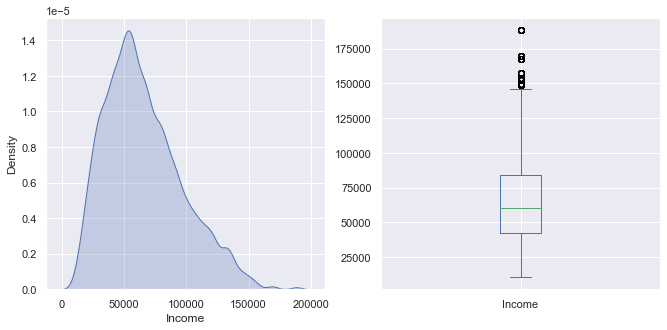

In [33]:
plt.subplot(121)
sns.kdeplot(df.Income,shade=True)
plt.subplot(122)
data["Income"].plot.box(figsize=(11,5))
plt.show()

### `2. Total Business Value variable stats`
* Total Business Value is slight right skewed.
* Income has no null value, has outliers as per the Box plot
* Min income is -6.000000e+06 , Max is 3.374772e+07
* Average income is 5.716621e+05
* As the variable is large values we will take log to check its true distribution.
* Log distribution seems to follow slight normal shape.

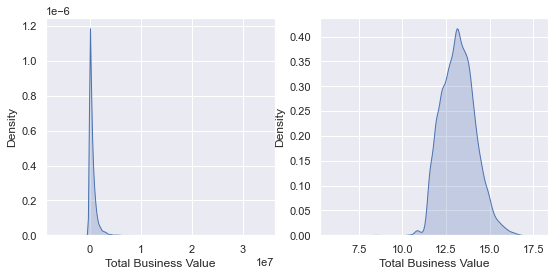

In [34]:
#start_scan_to_end_scan
sns.set(rc={'figure.figsize':(9,4)})
plt.subplot(121)
sns.kdeplot(df['Total Business Value'],shade=True)
plt.subplot(122)
sns.kdeplot(np.log(df['Total Business Value']),shade=True)
plt.show()

<AxesSubplot:xlabel='Total Business Value'>

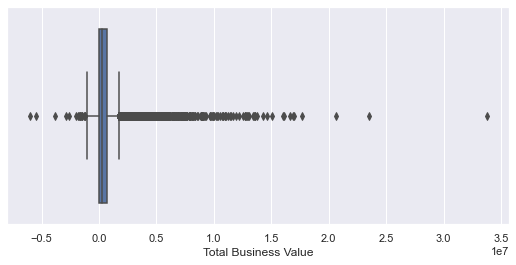

In [35]:
sns.boxplot(x=df['Total Business Value'])

# `Bivariate Analysis`
## >Check correlation in features <

* Total of 3 numerical variable. 
* No variable has strong linear relation with other variable.
* There are outliers in data.

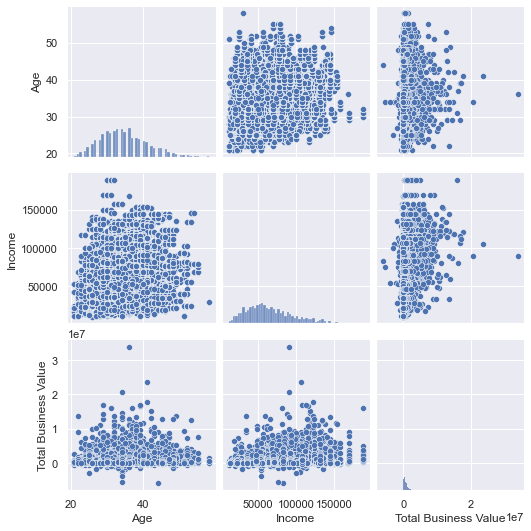

In [36]:
sns.pairplot(data=df[num_cols[1:]])
plt.show()

<AxesSubplot:>

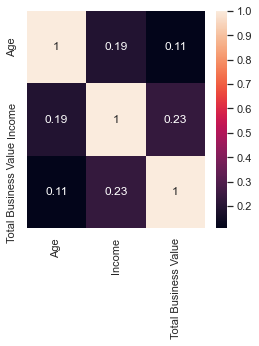

In [37]:
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(df[num_cols[1:]].corr(), annot = True)

In [38]:
cat_cols

['Gender',
 'City',
 'Education_Level',
 'Joining Designation',
 'Grade',
 'Quarterly Rating']

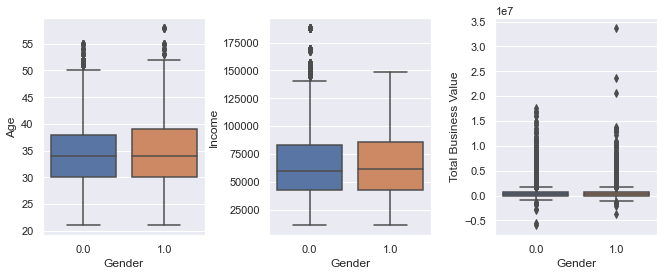

In [39]:
sns.set(rc={'figure.figsize':(11,4)})
names = df[num_cols[1:]].columns
ncols = len(names)
fig, axes = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4)
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "Gender", data=df, orient='v', ax=ax)

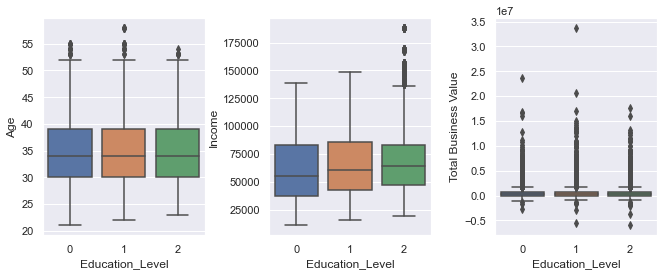

In [40]:
sns.set(rc={'figure.figsize':(11,4)})
names = df[num_cols[1:]].columns
ncols = len(names)
fig, axes = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4)
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "Education_Level", data=df, orient='v', ax=ax)

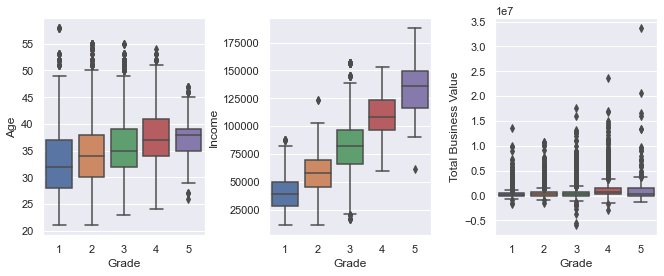

In [41]:
sns.set(rc={'figure.figsize':(11,4)})
names = df[num_cols[1:]].columns
ncols = len(names)
fig, axes = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4)
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "Grade", data=df, orient='v', ax=ax)

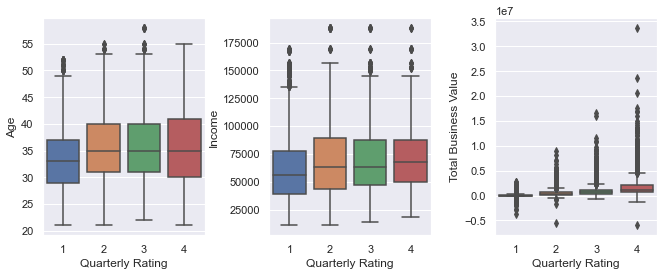

In [42]:
sns.set(rc={'figure.figsize':(11,4)})
names = df[num_cols[1:]].columns
ncols = len(names)
fig, axes = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4)
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "Quarterly Rating", data=df, orient='v', ax=ax)

#### ---------------------------------------------------------------------------------------------------------------------------
## `2. Data Preprocessing`
## Feature Engineering

In [43]:
df['Quarterly Rating'] = df['Quarterly Rating'].astype('int64')
df['Grade'] = df['Grade'].astype('int64')

### `Creating 'Target','Rating_Increase' column to check if rating has increased`
* Create a column which tells whether the quarterly rating has increased for that driver <br> for those whose quarterly rating has increased we assign the value 1
* A Dataframe is too find rating difference between latest rating minus initial rating
* B Dataframe is for distinct values of Driver_ID for merging
* T Dataframe is for Target variable

In [44]:
A = pd.DataFrame( (df.groupby(['Driver_ID'],as_index=False).agg({'Quarterly Rating':'first'}
           ).loc[:,'Quarterly Rating']-df.groupby(['Driver_ID'], as_index=False).agg(
    {'Quarterly Rating':'last'}).loc[:,'Quarterly Rating']).apply(lambda x: 1 if x < 0 else 0))

B = pd.DataFrame(df.Driver_ID.unique(), columns=['Driver_ID'])

In [45]:
d1 = df.groupby(['Driver_ID'],as_index=False).agg({'LastWorkingDate':'max'}).fillna(0)
T = d1.LastWorkingDate.apply(lambda x: 1 if x != 0 else 0)

### `Add 'Income Increase' and Grade_Change' new feature`
* Create a column which tells whether the monthly income has increased for that driver<br> for those whose monthly income has increased we assign the value 1
* Only 43 Drivers out of 2381 drivers had there income increase in 2019-2020.

In [46]:
Q1 = pd.DataFrame( (df.groupby(['Driver_ID'],as_index=False).agg({'Income':'first'}
           ).loc[:,'Income']-df.groupby(['Driver_ID'], as_index=False).agg(
    {'Income':'last'}).loc[:,'Income']).apply(lambda x: 1 if x < 0 else 0))

Q2 = pd.DataFrame( (df.groupby(['Driver_ID'],as_index=False).agg({'Grade':'first'}
           ).loc[:,'Grade']-df.groupby(['Driver_ID'], as_index=False).agg(
     {'Grade':'last'}).loc[:,'Grade']).apply(lambda x: 1 if x !=0 else 0))

In [47]:
C = pd.concat((B,A,Q1,Q2,T), axis=1)
C.rename(columns = {'Quarterly Rating':'Quatrly_Ratng_Inc',
                    'Income':'Income_Inc',
                    'Grade':'Grade_Change',
                    'LastWorkingDate':'Target' }, inplace = True)
C.head()

,Driver_ID,Quatrly_Ratng_Inc,Income_Inc,Grade_Change,Target
0,1,0,0,0,1
1,2,0,0,0,0
2,4,0,0,0,1
3,5,0,0,0,1
4,6,1,0,0,0


In [48]:
df.columns

Index(['MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Income', 'Dateofjoining', 'LastWorkingDate', 'Joining Designation',
       'Grade', 'Total Business Value', 'Quarterly Rating'],
      dtype='object')

In [49]:
df[['Age','Gender']] = df[['Age','Gender']].fillna(0)
df[['Age','Gender','Education_Level','Joining Designation']
  ] = df[['Age','Gender','Education_Level','Joining Designation']].astype('int64')

In [50]:
df1 = df.groupby(['Driver_ID'], as_index=False).agg({
    'Age':'max', 'Gender':'max','Education_Level':'last',
    'Income':'max', 'Joining Designation':'last',
    'Grade':'max', 'Total Business Value':'sum',
    })
df1.head()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value
0,1,28,0,2,57387,1,1,1715580
1,2,31,0,2,67016,2,2,0
2,4,43,0,2,65603,2,2,350000
3,5,29,0,0,46368,1,1,120360
4,6,31,1,1,78728,3,3,1265000


### One-Hot encoding on 'Quarterly Rating' then Aggregrate

In [51]:
QR = df[['Driver_ID','Quarterly Rating']].drop_duplicates()
QR = pd.get_dummies(QR, columns=['Quarterly Rating'])

QR = QR.groupby(['Driver_ID'], as_index=False).agg({
    'Quarterly Rating_1':'sum','Quarterly Rating_2':'sum',
    'Quarterly Rating_3':'sum','Quarterly Rating_4':'sum'})
QR.head()

,Driver_ID,Quarterly Rating_1,Quarterly Rating_2,Quarterly Rating_3,Quarterly Rating_4
0,1,0,1,0,0
1,2,1,0,0,0
2,4,1,0,0,0
3,5,1,0,0,0
4,6,1,1,0,0


### One-Hot encoding on 'City'

In [52]:
CT = df[['Driver_ID','City']].drop_duplicates()
CT = pd.get_dummies(CT, columns=['City'])
CT.head()

,Driver_ID,City_C1,City_C10,City_C11,City_C12,City_C13,City_C14,City_C15,City_C16,City_C17,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,4,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,6,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df1 = pd.merge(df1, QR, on='Driver_ID', how='inner')
df1 = pd.merge(df1, C, on='Driver_ID', how='inner')
df1 = pd.merge(df1, CT, on='Driver_ID', how='inner')
df1

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating_1,Quarterly Rating_2,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,1,28,0,2,57387,1,1,1715580,0,1,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,2,67016,2,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,4,43,0,2,65603,2,2,350000,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5,29,0,0,46368,1,1,120360,1,0,...,0,0,0,0,0,0,0,0,0,1
4,6,31,1,1,78728,3,3,1265000,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2376,2784,34,0,0,82815,2,3,21748820,1,0,...,0,0,0,0,0,0,0,0,0,0
2377,2785,34,1,0,12105,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2378,2786,45,0,0,35370,2,2,2815090,1,1,...,0,0,0,0,0,0,0,0,0,0
2379,2787,28,1,2,69498,1,1,977830,1,1,...,0,0,0,0,0,0,0,0,0,0


### Now we have 1 row per 'Driver_ID' hence 'Driver_ID' can be dropped

In [54]:
df1.drop('Driver_ID', axis =1, inplace= True)

## `KNN Imputation:`
 * As there is No Null values after final aggregtion, imputation is not required.

In [55]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2381 entries, 0 to 2380
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Age                   2381 non-null   int64
 1   Gender                2381 non-null   int64
 2   Education_Level       2381 non-null   int64
 3   Income                2381 non-null   int64
 4   Joining Designation   2381 non-null   int64
 5   Grade                 2381 non-null   int64
 6   Total Business Value  2381 non-null   int64
 7   Quarterly Rating_1    2381 non-null   uint8
 8   Quarterly Rating_2    2381 non-null   uint8
 9   Quarterly Rating_3    2381 non-null   uint8
 10  Quarterly Rating_4    2381 non-null   uint8
 11  Quatrly_Ratng_Inc     2381 non-null   int64
 12  Income_Inc            2381 non-null   int64
 13  Grade_Change          2381 non-null   int64
 14  Target                2381 non-null   int64
 15  City_C1               2381 non-null   uint8
 16  City_C

In [56]:
df1.head()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating_1,Quarterly Rating_2,Quarterly Rating_3,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
0,28,0,2,57387,1,1,1715580,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,31,0,2,67016,2,2,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,43,0,2,65603,2,2,350000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,29,0,0,46368,1,1,120360,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,31,1,1,78728,3,3,1265000,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Statistical summary of the derived dataset

In [57]:
df1.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating_1,Quarterly Rating_2,Quarterly Rating_3,...,City_C27,City_C28,City_C29,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,...,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.663167,0.410332,1.00756,59336.159597,1.820244,2.097018,4.586742e+06,0.875682,0.412432,0.258715,...,0.037379,0.034439,0.040319,0.034439,0.032339,0.033599,0.032759,0.031919,0.037379,0.031499
std,5.983375,0.491997,0.81629,28383.012146,0.841433,0.941702,9.127115e+06,0.330013,0.492375,0.438021,...,0.189729,0.182393,0.196748,0.182393,0.176937,0.180233,0.178043,0.175822,0.189729,0.174700
min,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,1.00000,55315.000000,2.000000,2.000000,8.176800e+05,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,1.000000,2.00000,75986.000000,2.000000,3.000000,4.173650e+06,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Outlier Treatment 
### 'Income' 
  * Quantile based flooring and capping

<AxesSubplot:xlabel='Income'>

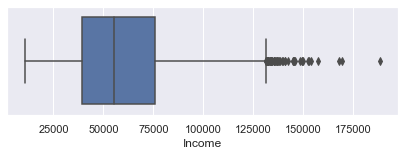

In [58]:
sns.set(rc={'figure.figsize':(7,2)})
sns.boxplot(df1.Income)

<AxesSubplot:xlabel='Income'>

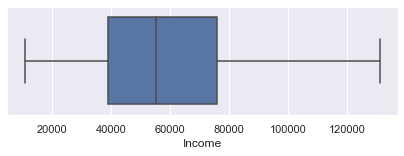

In [59]:
q1 = np.percentile(df1.Income, 25)
q3 = np.percentile(df1.Income, 75)
IQR = q3-q1
lwr_bound = q1-(1.5*IQR)
upr_bound = q3+(1.5*IQR)
df1.Income = np.where(df1.Income < lwr_bound, lwr_bound, df1.Income)
df1.Income = np.where(df1.Income > upr_bound, upr_bound, df1.Income)
sns.boxplot(df1.Income)

### 'Total Business Value'

<AxesSubplot:xlabel='Total Business Value'>

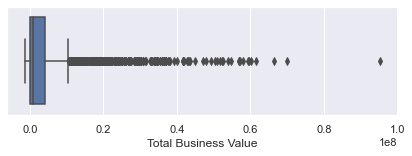

In [60]:
sns.boxplot(df1['Total Business Value'])

<AxesSubplot:xlabel='Total Business Value'>

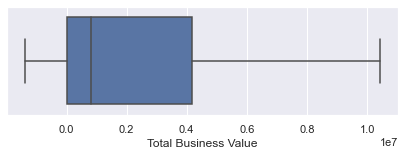

In [61]:
q1 = np.percentile(df1['Total Business Value'], 25)
q3 = np.percentile(df1['Total Business Value'], 75)
IQR = q3-q1
lwr_bound = q1-(1.5*IQR)
upr_bound = q3+(1.5*IQR)
df1['Total Business Value'] = np.where(df1['Total Business Value'] < lwr_bound, lwr_bound, df1['Total Business Value'])
df1['Total Business Value'] = np.where(df1['Total Business Value'] > upr_bound, upr_bound, df1['Total Business Value'])
sns.boxplot(df1['Total Business Value'])

### `Check Class Imbalance`

In [62]:
df1.Target.value_counts(normalize=True)*100

1    67.870643
0    32.129357
Name: Target, dtype: float64

### `Standardization`
#### Defining X and Y of our data:

In [63]:
Y = df1["Target"]
X = df1.drop(columns = ["Target"])

#### Train, Validation, Test Split

In [64]:
from sklearn.model_selection import train_test_split

X = np.array(X.values)
Y = np.array(Y.values)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

print(f"Sizes of the sets created are:\nTraining set:{X_train.shape[0]}\nTest set:{X_test.shape[0]}")

Sizes of the sets created are:
Training set:1904
Test set:477


In [65]:
from sklearn.preprocessing import StandardScaler
MM = MinMaxScaler()
X_train_MM = MM.fit_transform(X_train)
X_test_MM = MM.fit_transform(X_test)

# `Boosting`

In [66]:
from sklearn.ensemble import GradientBoostingClassifier as GBC

model3 = GBC(n_estimators=200, learning_rate=0.23, max_depth=4, random_state=0, verbose = 1).fit(X_train_MM, Y_train)
print(f"Training accuracy:{model3.score(X_train_MM, Y_train)}\nTest Accuracy: {model3.score(X_test_MM, Y_test)}")

      Iter       Train Loss   Remaining Time 
         1           1.1116            1.38s
         2           1.0271            1.10s
         3           0.9697            1.07s
         4           0.9301            0.99s
         5           0.8998            0.91s
         6           0.8758            0.85s
         7           0.8578            0.83s
         8           0.8399            0.82s
         9           0.8263            0.79s
        10           0.8110            0.78s
        20           0.7220            0.69s
        30           0.6625            0.68s
        40           0.6097            0.66s
        50           0.5665            0.63s
        60           0.5095            0.59s
        70           0.4734            0.56s
        80           0.4313            0.52s
        90           0.4021            0.47s
       100           0.3781            0.41s
       200           0.2022            0.00s
Training accuracy:0.993172268907563
Test Accuracy: 0.7

## `Feature Importance plot`

Text(0.5, 1.0, 'Feature Importance (MDI)')

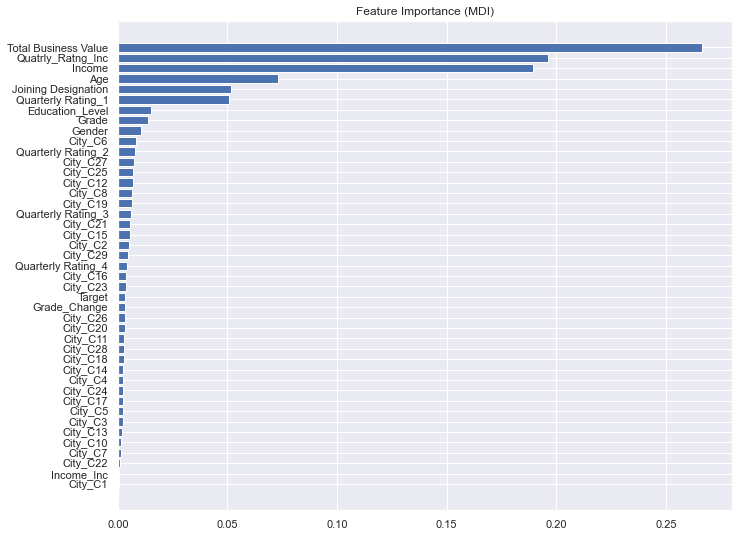

In [67]:
feature_importance = model3.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(11, 9))

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df1.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

### Plotting loss

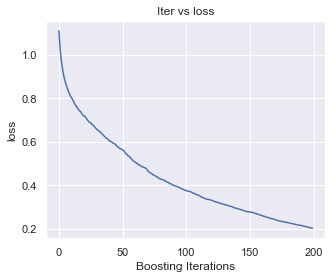

In [68]:
sns.set(rc={'figure.figsize':(5,4)})
plt.plot(model3.train_score_)

plt.xlabel("Boosting Iterations")
plt.ylabel('loss')
plt.title('Iter vs loss')
plt.show()

In [69]:
y_pred_test = model3.predict(X_test_MM)
print('F1 score:', f1_score(Y_test, y_pred_test))

F1 score: 0.8567375886524823


# ` Boosting Results Evaluation`
  * ROC AUC Curve & comments
  * Classification Report (Confusion Matrix etc)

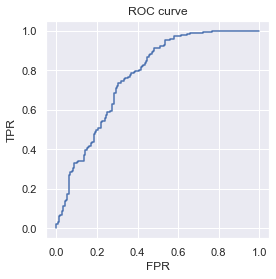

Area under ROC AUC Curve : 0.7699443413729128


In [70]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_prob2 = model3.predict_proba(X_test_MM)
fpr, tpr, thr = roc_curve(Y_test,np.ravel(pred_prob2[:,1]))
plt.subplots(figsize=(4,4))
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print('Area under ROC AUC Curve :', roc_auc_score(Y_test,np.ravel(pred_prob2[:,1])))

[[ 74  73]
 [ 28 302]]


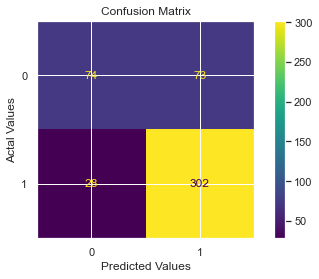

In [71]:
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(Y_test, model3.predict(X_test_MM))

#Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(7,4))
cmp = ConfusionMatrixDisplay(conf_mat, display_labels=np.arange(2))
cmp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
print(conf_mat)
plt.show()

# `Bagging  using  RandomForest`

Training accuracy:0.7899159663865546
Test Accuracy: 0.80083857442348
              precision    recall  f1-score   support

           0       0.81      0.46      0.59       147
           1       0.80      0.95      0.87       330

    accuracy                           0.80       477
   macro avg       0.80      0.71      0.73       477
weighted avg       0.80      0.80      0.78       477

F1 score: 0.8686030428769018


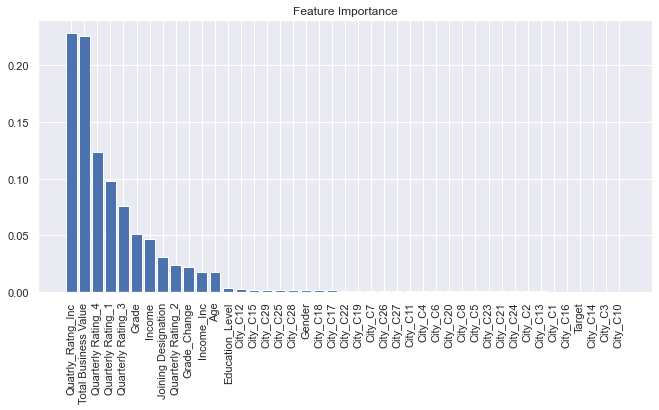

In [86]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.utils  import ClassWeight

clf = RandomForestClassifier(max_depth=4, n_estimators=200)
clf.fit(X, Y)
print(f"Training accuracy:{clf.score(X_train, Y_train)}\nTest Accuracy: {clf.score(X_test, Y_test)}")
print(classification_report(Y_test, clf.predict(X_test)))
print('F1 score:',f1_score(Y_test, clf.predict(X_test)))
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [df1.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(11, 5)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

Training accuracy:0.7962184873949579
Test Accuracy: 0.7756813417190775
              precision    recall  f1-score   support

           0       0.65      0.59      0.62       147
           1       0.83      0.86      0.84       330

    accuracy                           0.78       477
   macro avg       0.74      0.72      0.73       477
weighted avg       0.77      0.78      0.77       477

F1 score: 0.8410104011887073


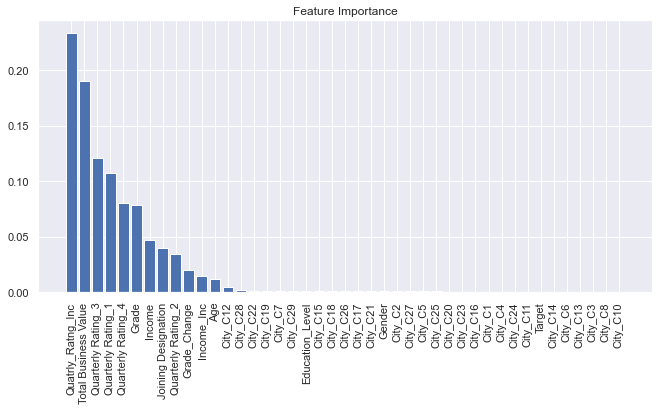

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight

clf = RandomForestClassifier(max_depth=3, n_estimators=200, class_weight ='balanced')
clf.fit(X, Y)
print(f"Training accuracy:{clf.score(X_train, Y_train)}\nTest Accuracy: {clf.score(X_test, Y_test)}")
print(classification_report(Y_test, clf.predict(X_test)))
print('F1 score:',f1_score(Y_test, clf.predict(X_test)))
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [df1.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(11, 5)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

## Bagging Evaluation: 

In [84]:
print(classification_report(Y_test, clf.predict(X_test)))
print('F1 score:',f1_score(Y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.45      0.58       147
           1       0.80      0.95      0.87       330

    accuracy                           0.80       477
   macro avg       0.81      0.70      0.72       477
weighted avg       0.80      0.80      0.78       477

F1 score: 0.8677685950413222


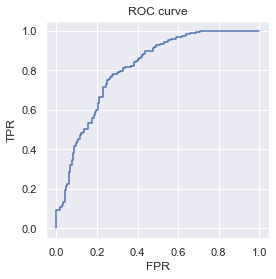

Area under ROC AUC Curve : 0.809647495361781


In [74]:
pred_prob2 = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(Y_test,np.ravel(pred_prob2[:,1]))
plt.subplots(figsize=(4,4))
plt.plot(fpr,tpr)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print('Area under ROC AUC Curve :', roc_auc_score(Y_test,np.ravel(pred_prob2[:,1])))

[[ 66  81]
 [ 15 315]]


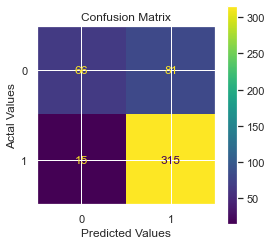

In [75]:
conf_mat = confusion_matrix(Y_test, clf.predict(X_test))

#Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(4,4))
cmp = ConfusionMatrixDisplay(conf_mat, display_labels=np.arange(2))
cmp.plot(ax=ax)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
print(conf_mat)
plt.show()

### Other additional analysis based on Boosting/ Bagging Evaluation:

<AxesSubplot:xlabel='Quatrly_Ratng_Inc'>

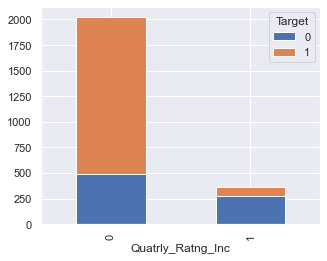

In [76]:
pd.crosstab(df1['Quatrly_Ratng_Inc'], df1['Target']).plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='Grade'>

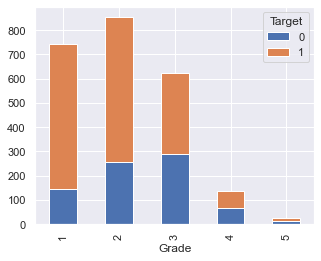

In [77]:
pd.crosstab(df1['Grade'], df1['Target']).plot(kind='bar', stacked=True)

In [78]:
pd.crosstab(df1['Grade'], df1['Target'],margins = True,normalize='all').round(4)*100

Target,0,1,All
Grade,,,
1,6.09,25.03,31.12
2,10.67,25.20,35.87
3,12.05,14.15,26.21
4,2.86,2.94,5.80
5,0.46,0.55,1.01
All,32.13,67.87,100.00


Target,0,1,All
Income_Inc,,,
0,30.45,67.74,98.19
1,1.68,0.13,1.81
All,32.13,67.87,100.00


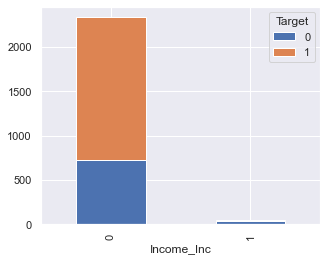

In [79]:
pd.crosstab(df1['Income_Inc'], df1['Target']).plot(kind='bar', stacked=True)
pd.crosstab(df1['Income_Inc'], df1['Target'],margins = True,normalize='all').round(4)*100

<AxesSubplot:xlabel='Education_Level'>

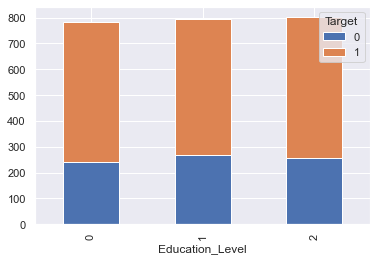

In [80]:
sns.set(rc={'figure.figsize':(6,4)})
pd.crosstab(df1['Education_Level'], df1['Target']).plot(kind='bar', stacked=True)

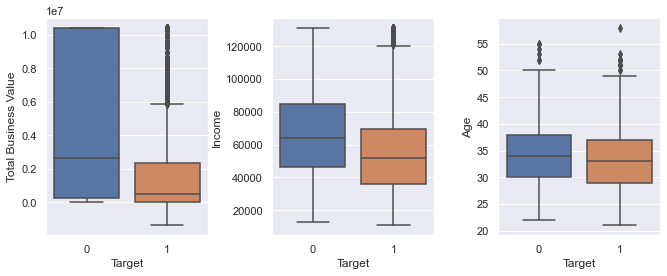

In [81]:
sns.set(rc={'figure.figsize':(11,4)})
names = df1[['Total Business Value','Income','Age']].columns
ncols = len(names)
fig, axes = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.4)
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= "Target", data=df1, orient='v', ax=ax)

# `Actionable Insights & Recommendations`

1.	Drivers who left have negligible salary hike.
2.	Drivers who left have lesser income median as compare to who did not exit.
3.	Total Business Value generated by non-churn drivers much higher than churn drivers.
4.	Grade ‘1’ drivers churn more than other Grade drivers.
5.	Age do not have much impact on driver churn. 
6.	City, Education_Level also not have much impact on driver churn. 
<br>
<br>
7.	Additional info is required to make more accurate prediction like <br>
    •	Hours spent in driving<br>
    •	Miles covered per day<br>
    •	Climate Temperature <br>
    •	Average min per trip <br>
8. Salary increment would help retain more drivers.
9. Lunch food coupons will also help in stopping driver churn.
10. More Proactive counselling will help better understand concerns of drivers.